In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import shutil
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from zipfile import ZipFile
from PIL import Image
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-23 19:17:56.568097: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 19:17:56.568289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 19:17:56.752751: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/facial-keypoints-detection/training.zip
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/test.zip


In [2]:
#Extract the zipped data
trainZip = ZipFile("/kaggle/input/facial-keypoints-detection/training.zip")
trainZip.extractall("/kaggle/working")
testZip = ZipFile("/kaggle/input/facial-keypoints-detection/test.zip")
testZip.extractall("/kaggle/working")
#Load all the relevant items into assorted tables
trainingTable = pd.read_csv("/kaggle/working/training.csv")
testTable = pd.read_csv("/kaggle/working/test.csv")
lookupTable = pd.read_csv("/kaggle/input/facial-keypoints-detection/IdLookupTable.csv")
sampleSubmit = pd.read_csv("/kaggle/input/facial-keypoints-detection/SampleSubmission.csv")

## Problem Statement and Data Examination

[For this project I will be attempting the Facial Keypoints Detection Kaggle competition.](https://www.kaggle.com/competitions/facial-keypoints-detection) The task of this project is to predict the location of facial feature in a dataset comprised exclusively of facial close ups.

To begin let's look at the data. In the data, we are given the location of 15 facial features as x/y coordinates, comprising a total of 30 features columns plus the image column. For training we have 7049 images to work with. The images are 96x96 greyscale images, per the Kaggle problem description. Notably a considerable number of images have null values, which will have to be dealt with.

In [3]:
## Basic look around the data
trainingTable.info()
trainingTable.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


To get a better sense of the inputs, I've plotted out the first five images in the data set. As can be seen below, this subset are close up photos with the full face present. Additionally, you can see that some number of people have been reused with different expressions as shown by pictures 1 and 5. Also, these particular images are likely to have very similar facial feature locations, for some features, due to how the images are framed. The eye Y-axis values are likely very closely distributed. The eye X-axis values are likely wider distributed, but I would expect the standard deviation of the positions to be fairly small.

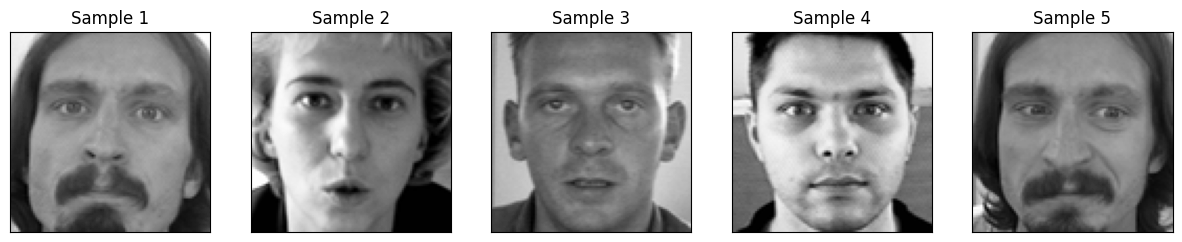

In [4]:
## Define function to convert the image string array to a numpy float array properly shaped
def arrayToImage(imageArray,imageSize=(96,96),rescale=None):
    ret = np.array([float(x) for x in imageArray.split()])
    ret = ret.reshape(imageSize)
    if rescale is not None:
        ret = np.multiply(ret,rescale)
    return(ret)

## Plot a few sample images
f = plt.figure(figsize=(15,10))
for idx in range(5):
    im = arrayToImage(trainingTable.Image[idx])
    ax = plt.subplot(1,5,idx+1,title="Sample %d"%(idx+1))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(im,cmap="gist_gray")

Next, we'll look at an image that is missing some features to see why.

We index into all images that are missing the left corner of the mouth and pull out the first one on the list. From the data we can see that it has been encoded that this image lacks the right eye center, right eye inner and outer corners, and the mouth left and right corners.

When we display the image we see a photo of a feminine face in profile with their left side facing us. This accounts for why everything related to the right eye is missing. Concerningly, the corner of the left corner of the mouth is clearly present. It is ambiguous why it was excluded. Similarly, the right eyebrow is included with a full suite of values despite not being present in the images. I would suspect that this dataset could use deeper cleaning and notation than has been provided. Such cleaning is outside the scope of this project and will not be attempted.

From this photo we can infer a few things about the data without digging through all 7049 entries. The photos feature faces both in portrait and in profile. Presumably angles in between, but without further investigation, that cannot be definitively said. This implies that the Y-axis values of the faces will likely be closely distributed for most if not all images, due to the framing of the photos and general anatomy, the X-axis values will likely be wider distributed than previously expected.

index                                                                     1620
left_eye_center_x                                                    40.458999
left_eye_center_y                                                    40.761635
right_eye_center_x                                                         NaN
right_eye_center_y                                                         NaN
left_eye_inner_corner_x                                              35.552085
left_eye_inner_corner_y                                              39.437385
left_eye_outer_corner_x                                              46.618306
left_eye_outer_corner_y                                              42.578631
right_eye_inner_corner_x                                                   NaN
right_eye_inner_corner_y                                                   NaN
right_eye_outer_corner_x                                                   NaN
right_eye_outer_corner_y                            

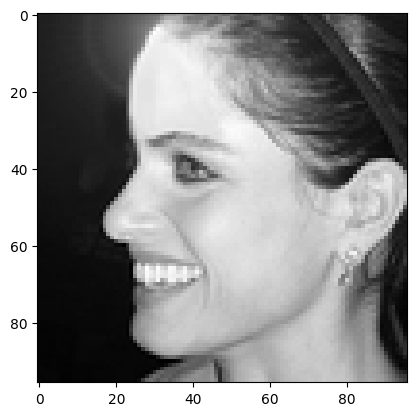

In [5]:
## Retrieve an image that is missing features
noMouth = trainingTable.loc[pd.isna(trainingTable["mouth_left_corner_x"]),:].reset_index()
print(noMouth.iloc[0])

## Plot image
noMouthImage = arrayToImage(noMouth.iloc[0].Image)
plt.imshow(noMouthImage,cmap="gist_gray")

To get an idea of how many photos are missing features, a quick percentage of NaN values per column.

From the table we can see that the center of each eye, the tip of the nose and the center of the bottom lip are present in nearly every photo. Every photo in the case of the nose. Also that two thirds of the lateral facial features are missing. I would guess that the dataset is comprised of 1/3 portrait photos and 2/3 left and right profile photos. Once more a deeper investigation of the dataset is out of scope for this project. The thing that concerns me is that the left and right eye center values are marked in nearly every photo, but corresponding lateral features are not. Once more, the dataset likely needs a once over.

In [6]:
## Check percentages of missing features
trainingTable.isna().sum() / trainingTable.shape[0] * 100

left_eye_center_x             0.141864
left_eye_center_y             0.141864
right_eye_center_x            0.184423
right_eye_center_y            0.184423
left_eye_inner_corner_x      67.782664
left_eye_inner_corner_y      67.782664
left_eye_outer_corner_x      67.839410
left_eye_outer_corner_y      67.839410
right_eye_inner_corner_x     67.825223
right_eye_inner_corner_y     67.825223
right_eye_outer_corner_x     67.825223
right_eye_outer_corner_y     67.825223
left_eyebrow_inner_end_x     67.796851
left_eyebrow_inner_end_y     67.796851
left_eyebrow_outer_end_x     68.435239
left_eyebrow_outer_end_y     68.435239
right_eyebrow_inner_end_x    67.796851
right_eyebrow_inner_end_y    67.796851
right_eyebrow_outer_end_x    68.279189
right_eyebrow_outer_end_y    68.279189
nose_tip_x                    0.000000
nose_tip_y                    0.000000
mouth_left_corner_x          67.811037
mouth_left_corner_y          67.811037
mouth_right_corner_x         67.796851
mouth_right_corner_y     

Finally, a look at the distributions of the features. Taking the left and right eye center coordinates, a couple of histograms to show their locations were made. As expected, the Y coordinates are nearly identically distributed and the X distributions have a different mean but very similar standard deviation.

Right Eye Center X Mean: 30.31
Left Eye Center X Mean: 66.36
Right Eye Center Y Mean: 37.98
Left Eye Center Y Mean: 37.65

Right Eye Center X Standard Deviation: 3.08
Left Eye Center X Standard Deviation: 3.45
Right Eye Center Y Standard Deviation: 3.03
Left Eye Center Y Standard Deviation: 3.15


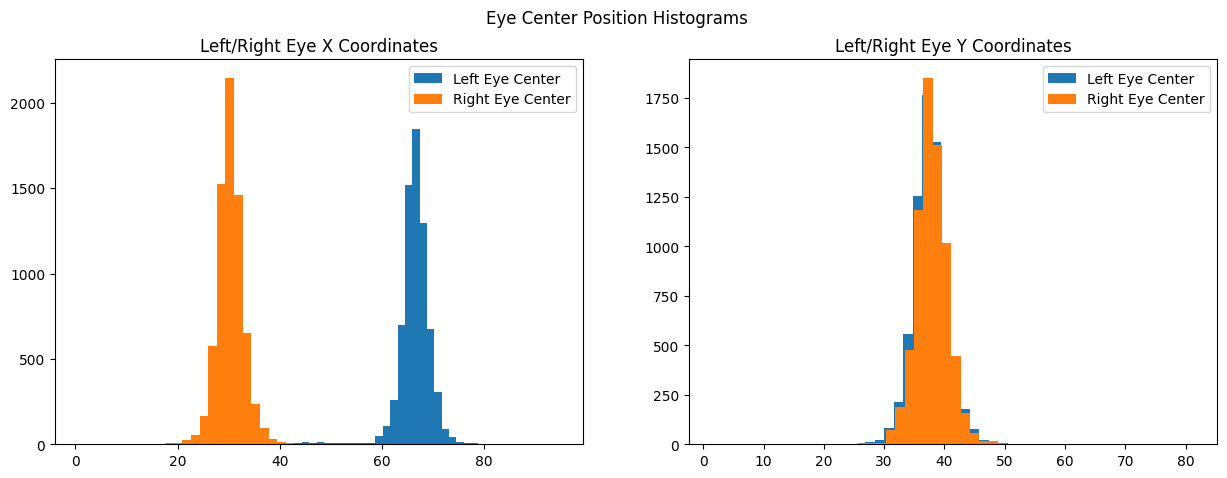

In [7]:
##Print out various means and standard deviations
print("Right Eye Center X Mean: %.2f"%trainingTable["right_eye_center_x"].mean())
print("Left Eye Center X Mean: %.2f"%trainingTable["left_eye_center_x"].mean())

print("Right Eye Center Y Mean: %.2f"%trainingTable["right_eye_center_y"].mean())
print("Left Eye Center Y Mean: %.2f"%trainingTable["left_eye_center_y"].mean())

print("")

print("Right Eye Center X Standard Deviation: %.2f"%trainingTable["right_eye_center_x"].std())
print("Left Eye Center X Standard Deviation: %.2f"%trainingTable["left_eye_center_x"].std())

print("Right Eye Center Y Standard Deviation: %.2f"%trainingTable["right_eye_center_y"].std())
print("Left Eye Center Y Standard Deviation: %.2f"%trainingTable["left_eye_center_y"].std())


##Plot out the typical coordinates of a the eye center features
f = plt.figure(figsize=(15,5),)
plt.suptitle("Eye Center Position Histograms")
ax = plt.subplot(1,2,1,title="Left/Right Eye X Coordinates")
plt.hist(trainingTable["left_eye_center_x"],bins=50)
plt.hist(trainingTable["right_eye_center_x"],bins=50)
plt.legend(["Left Eye Center","Right Eye Center"])
ax = plt.subplot(1,2,2,title="Left/Right Eye Y Coordinates")
plt.hist(trainingTable["left_eye_center_y"],bins=50)
plt.hist(trainingTable["right_eye_center_y"],bins=50)
plt.legend(["Left Eye Center","Right Eye Center"])

## Preprocessing

For the first model of this project, I'm going to make the problem simpler. The model will be trained on whether or not a given feature exists in the data. Given the prevalance of missing features, this seemed a simpler problem for the algorithm to attempt to solve, which could be built on for the final predictions.

To create this data set, a few preprocessing steps are taken:
* The images are cast from the string arrays to the normalized numpy float arrays
* A new table is generated from the original training data that is comprised of boolean values indicating if a feature is present in an image
* The original 30 features are condensed down to 14
    * Half of the features are removed due to no longer needing x/y coordinates
    * Nose tip is removed entirely due to being present in every photo
* Once condensed, the features are cast from booleans to floats to make tensorflow happy
    

In [8]:
## Cast the image string to the normalized version for training
trainingTable["NormImage"] = trainingTable["Image"].apply(lambda x: arrayToImage(x,rescale=1/255))

## Create a table of boolean values that describe if a given feature is present in an image
hasFeatures = trainingTable.drop(columns=["Image","NormImage"])
hasFeatures = hasFeatures.apply(pd.notnull)

## Create the column names as we go along
bilateralFeatureList = [
    "eye_center",
    "eye_inner_corner",
    "eye_outer_corner",
    "eyebrow_inner_end",
    "eyebrow_outer_end",
]
unilateralFeatureList = [
    "mouth_left_corner",
    "mouth_right_corner",
    "mouth_center_top_lip",
    "mouth_center_bottom_lip"
]

fullFeatureList = []

## Remove nose tip since it's present in all images
hasFeatures = hasFeatures.drop(columns = ["nose_tip_x","nose_tip_y"])

for x in bilateralFeatureList:
    hasFeatures["left_%s"%x] = hasFeatures["left_%s_x"%x]
    hasFeatures["right_%s"%x] = hasFeatures["right_%s_x"%x]
    hasFeatures = hasFeatures.drop(columns=["left_%s_x"%x,"right_%s_x"%x,"left_%s_y"%x,"right_%s_y"%x])
    fullFeatureList.append("left_%s"%x)
    fullFeatureList.append("right_%s"%x)
    
for x in unilateralFeatureList:
    hasFeatures[x] = hasFeatures["%s_x"%x]
    hasFeatures = hasFeatures.drop(columns=["%s_x"%x,"%s_y"%x])
    
fullFeatureList.extend(unilateralFeatureList)

hasFeatures = hasFeatures.astype(float)

#Staple the normalized image into the new table
hasFeatures["NormImage"] = trainingTable["NormImage"]
hasFeatures.head(5)

,left_eye_center,right_eye_center,left_eye_inner_corner,right_eye_inner_corner,left_eye_outer_corner,right_eye_outer_corner,left_eyebrow_inner_end,right_eyebrow_inner_end,left_eyebrow_outer_end,right_eyebrow_outer_end,mouth_left_corner,mouth_right_corner,mouth_center_top_lip,mouth_center_bottom_lip,NormImage
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"[[0.9333333333333333, 0.9254901960784314, 0.92..."
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"[[0.8588235294117647, 0.8431372549019608, 0.8,..."
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"[[0.5647058823529412, 0.5568627450980392, 0.62..."
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"[[0.7568627450980392, 0.7529411764705882, 0.75..."
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"[[0.5764705882352941, 0.580392156862745, 0.627..."


Finally the data is split out in an 80/20 training/validation split. The numpy image arrays had to be reformatted just a bit to be input to the model correctly.

In [9]:
## Split the data
trainData, testData = train_test_split(hasFeatures,test_size=.2)

## Fiddle with the shape of the array to make tensorflow happy
xTrain = trainData["NormImage"].to_numpy()
xTrain = np.concatenate(xTrain).reshape(xTrain.shape[0],96,96)
#Don't need the image on the output array
yTrain = trainData.drop(columns="NormImage").to_numpy()

## Do the above for the test data set
xTest = testData["NormImage"].to_numpy()
xTest = np.concatenate(xTest).reshape(xTest.shape[0],96,96)
yTest = testData.drop(columns="NormImage").to_numpy()

## Model 1

The first model is a fairly simple sequential convolutional one. This one is loosly based of the CycleGAN generator model encoding portion that used simple 3x3 filters and stride 2 to condense the image into an encoding layer. I've reduced the number of convolutional layers while keeping the stride 2 and flattened the final convolutional layer to be used before the dense output layer.

The model, more specifically, is comprised of:
* A set of 8, 3x3 convolutional filters, with stride 2
* A 2x2 max pooling layer
* Another set of 8, 3x3 convolutional filters, with stride 2
* A flatten layer
* A dense output layer with sigmoid activation

For training, the loss is set to binary cross entropy, due to the binary nature of the result. The model was set to train for 25 epochs and set to early stop if the validation loss did not improve within 5 epochs.

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(96,96,1)))
model.add(keras.layers.Conv2D(8,(3,3),strides=2,activation="relu"))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(8,(3,3),strides=2,activation="relu"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(14,activation="sigmoid"))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 47, 47, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 968)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │        13,566 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,230 (55.59 KB)

 Trainable params: 14,230 (55.59 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(
    optimizer="adam",
    loss = "binary_crossentropy"
)

history = model.fit(
    x = xTrain,
    y = yTrain,
    validation_data = (xTest,yTest),
    epochs = 25,
    callbacks = [earlyStopping]
)

Epoch 1/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5264 - val_loss: 0.4207
Epoch 2/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.4121 - val_loss: 0.3415
Epoch 3/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.3403 - val_loss: 0.3771
Epoch 4/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.3315 - val_loss: 0.2998
Epoch 5/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.3105 - val_loss: 0.3036
Epoch 6/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2939 - val_loss: 0.2931
Epoch 7/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2806 - val_loss: 0.2851
Epoch 8/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2801 - val_loss: 0.2798
Epoch 9/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2817 - val_loss: 0.2839
Epoch 10/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2798 - val_loss: 0.2744
Epoch 11/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2750 - val_loss: 0.2755
Epoch 12/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 

Once the model is trained, a few plots are generated to show how it did.

From the loss plot, we can see that it gradually improved. The training and validation curves separated after a few epochs, but both continued to decrease for the given set of epochs.

The other two plots show the feature detection accuracy and the change in accuracy from simply guessing the presence of a feature, respectively. It can be shown that for most features, it reached better than 85% accuracy, a little under 20% absolute increase in guessing accuracy. Notably, the mouth centers and the eye centers showed no accuracy improvement, but that's certainly due to them being present in more than 99% of the images. It's arguable that they should have been removed along with the nose tip. For now, the model shows promise in achieving reasonable success with the simpler task.

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Text(0.5, 1.0, 'Feature Detection Accuracy Delta')

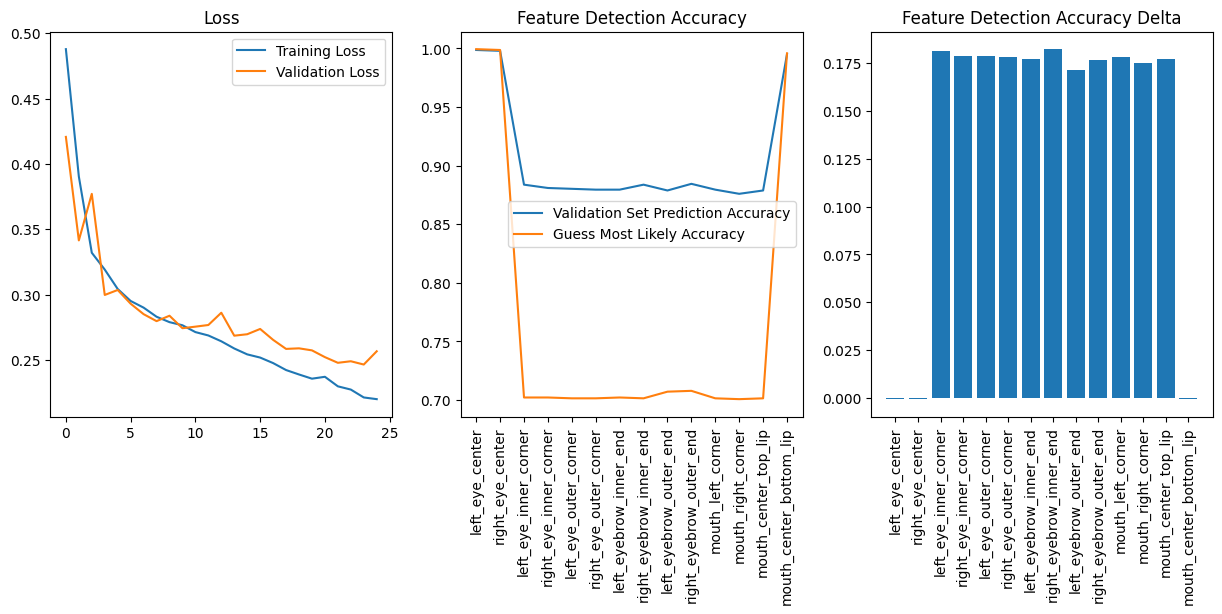

In [12]:
## Create predictions from the test set
t = model.predict(xTest)
t[t>.5]=1
t[t<=.5]=0
## Determine the accuracy if you guessed at the presence of any given feature
tc = testData.drop(columns="NormImage").to_numpy()
acc = np.sum(t==tc,axis=0)/tc.shape[0]
guessAcc = np.sum(tc,axis=0)/tc.shape[0]
## Take the complement of the guess if it's less than 50%
guessAcc[guessAcc<.5] = 1-guessAcc[guessAcc<.5]

f = plt.figure(figsize=(15,5))
##Plot the losses
ax = plt.subplot(1,3,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training Loss","Validation Loss"])
plt.title("Loss")
##Plot the accuracy of detecting features
ax = plt.subplot(1,3,2)
plt.plot(acc)
plt.plot(guessAcc)
plt.xticks(range(len(fullFeatureList)),fullFeatureList,rotation=90)
plt.legend(["Validation Set Prediction Accuracy","Guess Most Likely Accuracy"])
plt.title("Feature Detection Accuracy")
##Bar plot the difference between the prediction accuracy vs the guess accuracy
ax = plt.subplot(1,3,3)
plt.bar(fullFeatureList,acc-guessAcc)
plt.xticks(rotation=90)
plt.title("Feature Detection Accuracy Delta")

## Model 2

For the second model, I expanded the use of convolutions and had it compress the image more slowly. I removed the stride 2 for the lyaers, and added two more convolutional layers, with 2x2 max pools between them. As before, the final layer was flattened and fed to the output layer. The model was similarly compiled and fit as the previous model. Early stopping was removed due to unknown issues with it erroneously triggering.

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(96,96,1)))
model.add(keras.layers.Conv2D(8,(3,3),strides=1,activation="relu"))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(8,(3,3),strides=1,activation="relu"))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(8,(3,3),strides=1,activation="relu"))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(8,(3,3),strides=1,activation="relu"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(14,activation="sigmoid"))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 47, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         7,182 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,014 (35.21 KB)

 Trainable params: 9,014 (35.21 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(
    optimizer="adam",
    loss = "binary_crossentropy"
)

history = model.fit(
    x = xTrain,
    y = yTrain,
    validation_data = (xTest,yTest),
    epochs = 25,
    callbacks = [earlyStopping]
)

Epoch 1/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 0.5182 - val_loss: 0.4331
Epoch 2/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.4071 - val_loss: 0.3579
Epoch 3/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.3439 - val_loss: 0.3409
Epoch 4/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.3257 - val_loss: 0.3172
Epoch 5/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.3036 - val_loss: 0.3095
Epoch 6/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.2931 - val_loss: 0.2911
Epoch 7/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.2871 - val_loss: 0.2812
Epoch 8/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.2907 - val_loss: 0.2818
Epoch 9/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 0.2912 - val_loss: 0.2703
Epoch 10/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.2653 - val_loss: 0.2701
Epoch 11/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.2600 - val_loss: 0.2627
Epoch 12/25
177/177 ━━━━━━━━━━

As can be seen below, this model did demonstrably similarly to the first one there was even a very small improvement in one of the 99% guess features (right eye center). The loss curve does show that the model was probably overfitting, which makes the loss of using early stopping regrettable.

Because the model did similarly to the first one, with more complexity, thus greater computing resources consumed, the first one is chosen as the base for the final model.

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


Text(0.5, 1.0, 'Feature Detection Accuracy Delta')

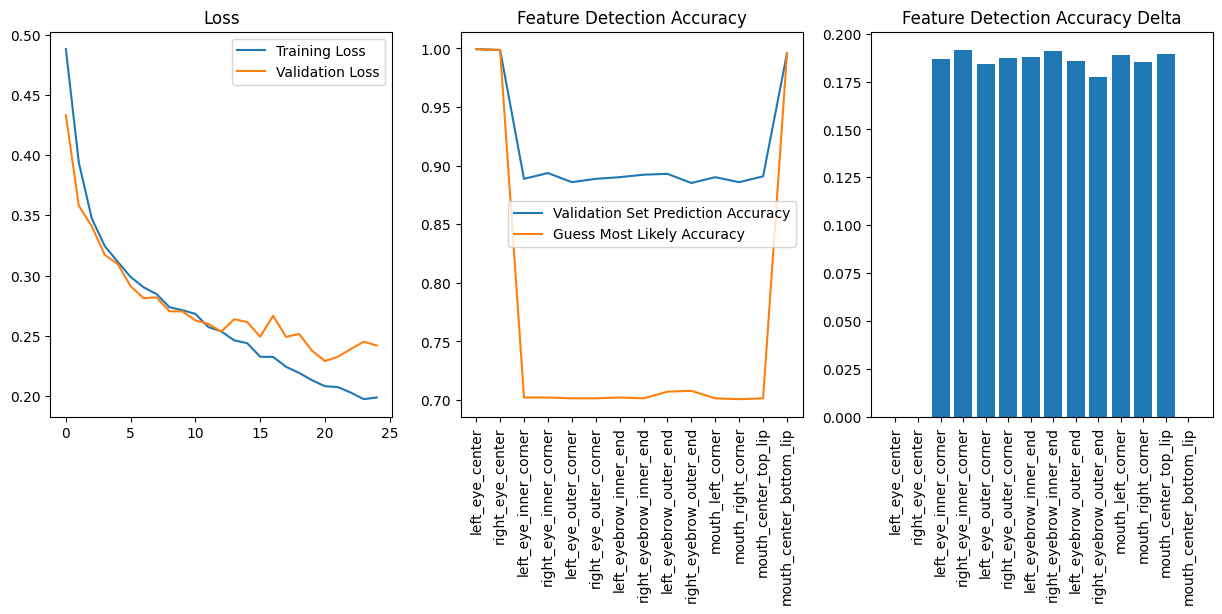

In [15]:
## Create predictions from the test set
t = model.predict(xTest)
t[t>.5]=1
t[t<=.5]=0
## Determine the accuracy if you guessed at the presence of any given feature
tc = testData.drop(columns="NormImage").to_numpy()
acc = np.sum(t==tc,axis=0)/tc.shape[0]
guessAcc = np.sum(tc,axis=0)/tc.shape[0]
## Take the complement of the guess if it's less than 50%
guessAcc[guessAcc<.5] = 1-guessAcc[guessAcc<.5]

f = plt.figure(figsize=(15,5))
##Plot the losses
ax = plt.subplot(1,3,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training Loss","Validation Loss"])
plt.title("Loss")
##Plot the accuracy of detecting features
ax = plt.subplot(1,3,2)
plt.plot(acc)
plt.plot(guessAcc)
plt.xticks(range(len(fullFeatureList)),fullFeatureList,rotation=90)
plt.legend(["Validation Set Prediction Accuracy","Guess Most Likely Accuracy"])
plt.title("Feature Detection Accuracy")
##Bar plot the difference between the prediction accuracy vs the guess accuracy
ax = plt.subplot(1,3,3)
plt.bar(fullFeatureList,acc-guessAcc)
plt.xticks(rotation=90)
plt.title("Feature Detection Accuracy Delta")

## Model 3

Now that we have a somewhat effective model to detect features, let's attempt to use it to determine their placement.

Before building, the training data needs to be reformatted. From the original data set, the images were once again processed back to numpy arrays. Instead of casting to booleans, this time the location values were left as is. The NaN values were set to -1, a value that does not exist in the data set. While other methods of handling NaNs certainly exist, this was the quickest method of handling the issue given the time contraints of the assignment. In theory, when a feature is not detected it should go to this value.

To get a sense of how all the parameters are distributed, a quick histogram is plotted. Other than the -1 spike, it shows that the features don't tend to be on the edges of the photos, which one would expect from the samples above.

Text(0.5, 1.0, 'General Location Distribution')

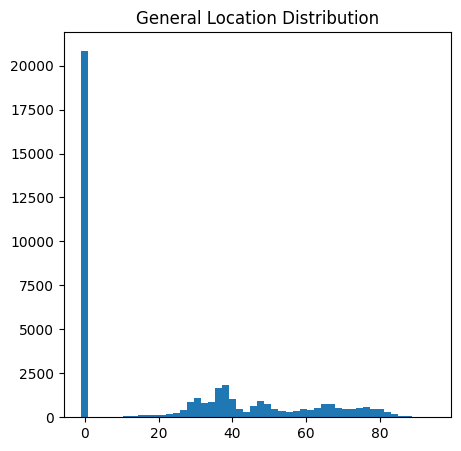

In [16]:
## Generate a training set of data to attempt predicting feature locations using the model from above
fullTrain = trainingTable.drop(columns="Image")
trainData2, testData2 = train_test_split(fullTrain,test_size=.2)
xTrain2 = trainData2["NormImage"].to_numpy()
xTrain2 = np.concatenate(xTrain2).reshape(xTrain2.shape[0],96,96)
yTrain2 = trainData2.drop(columns="NormImage").to_numpy()
## Define NaN values a -1, since that doesn't appear in the data set
yTrain2[np.isnan(yTrain2)] = -1
xTest2 = testData2["NormImage"].to_numpy()
xTest2 = np.concatenate(xTest2).reshape(xTest2.shape[0],96,96)
yTest2 = testData2.drop(columns="NormImage").to_numpy()
yTest2[np.isnan(yTest2)] = -1

f = plt.figure(figsize = (5,5,))
ax = plt.subplot(1,1,1)
plt.hist(yTest2.flatten(),bins=50)
plt.title("General Location Distribution")

For this model, the first one above was copied with one minor change. The output layer activation function was changed from a sigmoid to a linear function, due to now performing a regression instead of a classification. Similarly, the model loss function was set to the mean squared error instead of binary crossentropy for the same reason.

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(96,96,1)))
model.add(keras.layers.Conv2D(8,(3,3),strides=2,activation="relu"))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Conv2D(8,(3,3),strides=2,activation="relu"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(30,activation="linear"))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 47, 47, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 968)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │        29,070 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,734 (116.15 KB)

 Trainable params: 29,734 (116.15 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(
    optimizer="adam",
    loss = "MeanSquaredError"
)

history = model.fit(
    x = xTrain2,
    y = yTrain2,
    validation_data = (xTest2,yTest2),
    epochs = 25,
    callbacks = [earlyStopping]
)

Epoch 1/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 852.7249 - val_loss: 433.1406
Epoch 2/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 423.4795 - val_loss: 404.2990
Epoch 3/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 388.0118 - val_loss: 391.4435
Epoch 4/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 375.0907 - val_loss: 371.7511
Epoch 5/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 360.1887 - val_loss: 348.0463
Epoch 6/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 342.0750 - val_loss: 328.0277
Epoch 7/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 327.5346 - val_loss: 307.3475
Epoch 8/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 315.3080 - val_loss: 293.3637
Epoch 9/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 302.9719 - val_loss: 286.4221
Epoch 10/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 287.5135 - val_loss: 286.1767
Epoch 11/25
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 283.9495 - val_loss: 272.00

Below shows the results of the regression model. The loss curves show that it did well in training and little to no overfitting. The mean squared error and mean absolute error are shown per feature. The plots make it difficult to see, but the model struggles more with the X coordinates of the eye features and the Y coordinates of the mouth features.

Notably, the mean absolute error for some features are more than 20 pixels off. Further investigation into those items is warrented but not executed. The model does a good amount correctly, but has clear room for improvement.

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Text(0.5, 1.0, 'Feature Location MAE')

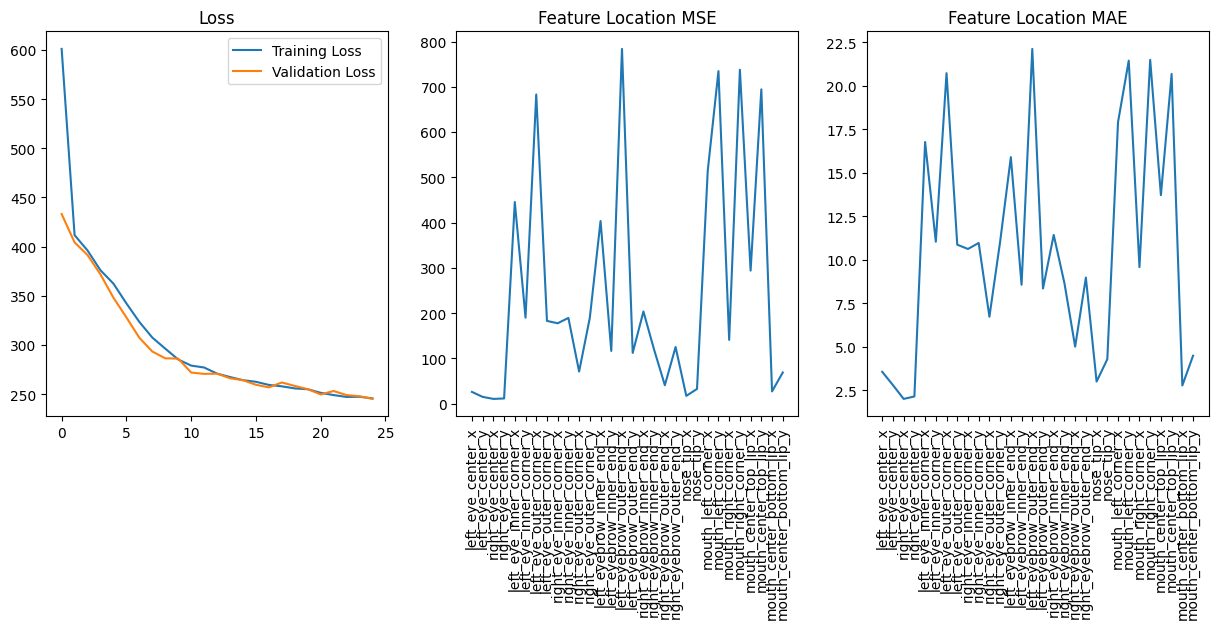

In [19]:
## Generate the location predictions
t = model.predict(xTest2)
squaredError = np.power(t-yTest2,2)
MSE = squaredError.sum(axis=0)/yTest2.shape[0]
absError = np.abs(t-yTest2)
MAE = absError.sum(axis=0)/yTest2.shape[0]

colNames = fullTrain.drop(columns="NormImage").columns

f = plt.figure(figsize=(15,5))
##Plot the losses
ax = plt.subplot(1,3,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training Loss","Validation Loss"])
plt.title("Loss")
## Plot the mean squared error
ax = plt.subplot(1,3,2)
plt.plot(MSE)
plt.xticks(range(len(colNames)),colNames,rotation=90)
plt.title("Feature Location MSE")
## Plot the mean absolute error
ax = plt.subplot(1,3,3)
plt.plot(MAE)
plt.xticks(range(len(colNames)),colNames,rotation=90)
plt.title("Feature Location MAE")

Finally a distribution of the errors is plotted for additional context. While most errors were within 20 pixels of the target, which isn't great, there were a nontrivial number of errors up to 60 pixels off. I would expect many of them to be the model attempting to place missing features. Once more, the model shows some effectiveness, but lots of room for improvement.

Text(0.5, 1.0, 'Absolute Error Distribution')

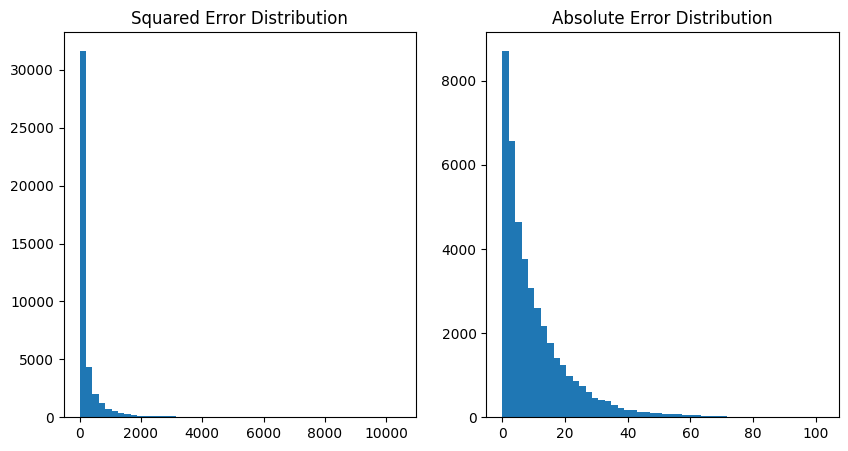

In [20]:
f = plt.figure(figsize=(10,5))
## Plot the distribution of the squared error
ax = plt.subplot(1,2,1)
plt.hist(squaredError.flatten(),bins=50)
plt.title("Squared Error Distribution")
## Plot the distribution of the absolute error
ax = plt.subplot(1,2,2)
plt.hist(absError.flatten(),bins=50)
plt.title("Absolute Error Distribution")

## Conclusion

The model was ultimately somewhat successful in the task presented.

The approach itself showed that a convolutional model, even a simple one, is effective for the task given. Given the simplicity of the model, further development has the advantage of being able to more rapidly generate models.

A few items that further development could do to improve the model:
* A better method of handling the NaN values. With more time and research it is likely that the model being able to handle such values without huge losses would improve it.
* More advanced layers. While the models is not so large that something like skip connections are needed, inception layers may be effective in training.
* A cleaner data set. As show above, there are clear issues with the data. Given that I was able to pull out such errors within 6 sample images, it's likely that there are more issues in the data set.
* Further hyperparameter tuning is always an option.

In [21]:
## Generate Kaggle submission
## Preprocess submission images
submissionImages = testTable.Image.apply(lambda x: arrayToImage(x,rescale=1/255))
submissionImages = submissionImages.to_numpy()
submissionImages = np.concatenate(submissionImages).reshape(submissionImages.shape[0],96,96)

## Predict Locations
t = model.predict(submissionImages)
t = pd.DataFrame(t,columns=colNames)

## Insert data into submission table and save
for idx,row in lookupTable.iterrows():
    im = t.iloc[row["ImageId"]-1]
    lookupTable.loc[lookupTable["RowId"] == row.RowId, "Location"] = im[row.FeatureName]
submission = lookupTable.drop(columns=["ImageId","FeatureName"])
submission.to_csv("submission.csv")

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
